# The Battle of Neighborhoods 
## New York: The City of Pizza

Although pizza originated in Naples, Italy many people associate the cosmopolitan metropolis of New York City with the dish.  It is likely the case that the modern day version of New York style pizza was created by Italian immigrants in New York City at the turn of the 20th Century.

In a city known for its availability of high-quality and cheap pizza shops, we are curious to know more about neighborhood differences in pizza availability throughout the city.

## Business Problem
If tourists wanted to sample local versions of pizza when visiting New York City what neighborhoods would be most efficient for trying different local shops?

Is it possible to use data to identify which neighborhoods offer the greatest availability of pizza?

Could a prospective pizza shop owner then use this data to identify neighborhoods with a surplus or lack of pizza shops?

# 1. Import Relevant Libraries

In [1]:
import numpy as np 

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

import seaborn as sns

print('Library Import Complete.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

## Define functions and parameters for future use in code

In [2]:
# Foursquare Credentials/Version

CLIENT_ID = 'JA3MI10L4RXQGRRBV422G3APWXTIDEALNA3O2MD3HNLHJQRO' 
CLIENT_SECRET = 'LWCRYIKTTML2W3U3W4TRWGZP4VXDSLHDHSQXIQFGHWWIREXA'
VERSION = '20200825' 

In [39]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude',] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Spot Check NYC Data

In [40]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape # Data indicates 306 Neighborhoods in NYC

(306, 4)

# Data Analysis

Initial look at distribution of neighborhoods per borough shows that Queens contains the highest number of neighborhoods, Manhattan the least

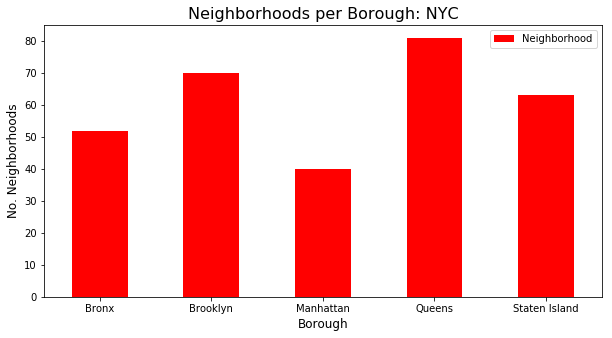

In [7]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No. Neighborhoods',fontsize = 12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


## Although many types of restaurants likely serve pizza, as the objective is to identify pizza specific establishments we have narrowed our focus to restaurants specifically designated as Pizza Places

In [79]:
# prepare neighborhood list that contains pizza shops
column_names=['Borough', 'Neighborhood', 'ID','Name']
pizza_nyc=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    pizza_restaurants=venues[venues['Category']=='Pizza Place']   
    print('(',count,'/',len(ny_data),')','Pizza Restaurants in '+Neighborhood+', '+Borough+':'+str(len(pizza_restaurants)))
    print(row)
    for resturant_detail in pizza_restaurants.values.tolist():
        id, name , category=resturant_detail
        pizza_nyc = pizza_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Pizza Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Pizza Restaurants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Pizza Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Pizza Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Pizza Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Pizza Restaurants in Kingsbridge, Bronx:6
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Pizza Restaurants in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Pizza Restaurants in Woodlawn, Bronx:3
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Pizza Restaurants in Norwood, Bronx:1
['Bronx', 'Norwood',

In [11]:
#Save as CSV to save on pulls
pizza_nyc.to_csv('pizza_nyc.csv')

In [52]:
pizza_nyc = pd.read_csv('pizza_nyc.csv')
pizza_nyc.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
310,310,Bronx,Kingsbridge Heights,52f5553d11d2e2288f60a8f1,Little Caesars Pizza
311,311,Bronx,Kingsbridge Heights,4d9fc532e8a6721ec2c429a5,Little Ceasars
312,312,Bronx,Kingsbridge Heights,4e4d03a6bd413c4cc66dfe9d,Kings Pizza
313,313,Brooklyn,Erasmus,4d41f0bfaed776ebb2a56997,Domino's Pizza
314,314,Brooklyn,Erasmus,4cc4d4cb38aaa093f5801562,Little Ceasars


In [80]:
pizza_nyc.shape # 315 establishments in NYC specifically designated as pizza places

(315, 4)

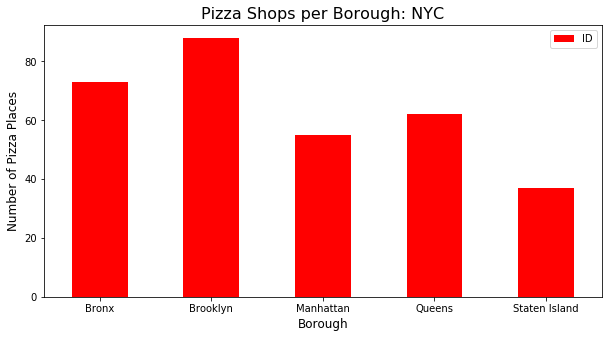

In [15]:
pizza_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Pizza Shops per Borough: NYC', fontsize = 16)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Number of Pizza Places', fontsize=12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Brooklyn contains the highest number of pizza shops, while Staten Island the least

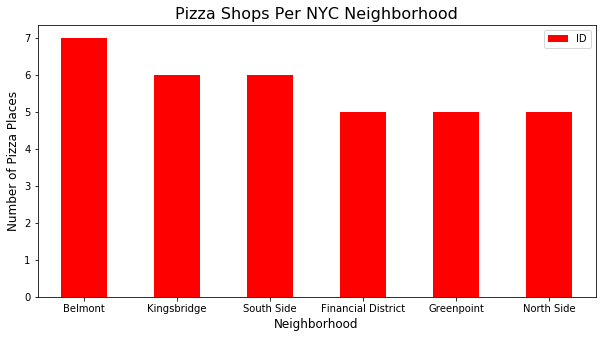

In [16]:
NOofNeigh = 6 # top number for graphing all the same past 6
pizza_nyc.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Pizza Shops Per NYC Neighborhood', fontsize = 16)
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('Number of Pizza Places', fontsize=12)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [17]:
pizza_nyc[pizza_nyc['Neighborhood']=='Belmont']

,Unnamed: 0,Borough,Neighborhood,ID,Name
48,48,Bronx,Belmont,4aee1220f964a520ced121e3,Full Moon Pizzeria
49,49,Bronx,Belmont,4aabd3e6f964a5204a5a20e3,Zero Otto Nove
50,50,Bronx,Belmont,4b140a90f964a520489c23e3,Bellini's Pizza
51,51,Bronx,Belmont,4b2a6ba8f964a520d9a824e3,Pugsley Pizza
52,52,Bronx,Belmont,4b97fc62f964a5202a2435e3,Tony & Tina's Pizza
53,53,Bronx,Belmont,4b180daaf964a52024cc23e3,University Pizza & Restaurant
54,54,Bronx,Belmont,575adfe8cd10afcbbf8d1a66,Bella Pizza


In [18]:
pizza_nyc[pizza_nyc['Neighborhood']=='Kingsbridge']

,Unnamed: 0,Borough,Neighborhood,ID,Name
2,2,Bronx,Kingsbridge,58935fd798f8aa7c14662653,Kingsbridge Social Club
3,3,Bronx,Kingsbridge,4bb114c4f964a520b9783ce3,Sam's Pizza
4,4,Bronx,Kingsbridge,4be72770910020a16f1ad514,Broadway Pizza & Pasta
5,5,Bronx,Kingsbridge,502bd9a6e4b0bea49203e0aa,Little Caesars Pizza
6,6,Bronx,Kingsbridge,5aa003f5b6eedb52c65bddb8,Papa John's Pizza
7,7,Bronx,Kingsbridge,4b4fbdb5f964a520811327e3,Domino's Pizza


In [19]:
pizza_nyc[pizza_nyc['Neighborhood']=='South Side']

,Unnamed: 0,Borough,Neighborhood,ID,Name
127,127,Brooklyn,South Side,55135426498e9dee8f19cc5f,L'Industrie Pizzeria
128,128,Brooklyn,South Side,5db9b79a76758b0008c18821,Leo
129,129,Brooklyn,South Side,570139a9498e16178005c729,Emmy Squared
130,130,Brooklyn,South Side,4b5f82d1f964a520b2be29e3,Roebling Pizza
131,131,Brooklyn,South Side,4cd453e4b97060fcdf48f07b,Zeff's Pizzeria
132,132,Brooklyn,South Side,4a297571f964a52093951fe3,Sabrina's Pizzeria


Belmont in Bronx has the most pizza places per neighborhood, while Kingsbirdge in Bronx and South Side in Brooklyn each have 6.  

## Based on the business problem of a tourist looking for opportunities to sample various pizza places in one trip let's look closer at these three neighborhoods

In [104]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Borough,Neighborhood,ID,ID.1,Name,Longitude,Latitude,Rating
0,48,48,Bronx,Belmont,4aee1220f964a520ced121e3,Full Moon Pizzeria,40.855300,-73.887600,9.0
1,49,49,Bronx,Belmont,4aabd3e6f964a5204a5a20e3,Zero Otto Nove,40.854800,-73.888500,8.8
2,50,50,Bronx,Belmont,4b140a90f964a520489c23e3,Bellini's Pizza,40.583000,-74.291500,8.6
3,51,51,Bronx,Belmont,4b2a6ba8f964a520d9a824e3,Pugsley Pizza,40.858770,-73.884812,9.2
4,52,52,Bronx,Belmont,4b97fc62f964a5202a2435e3,Tony & Tina's Pizza,40.857600,-73.886100,9.2
5,53,53,Bronx,Belmont,4b180daaf964a52024cc23e3,University Pizza & Restaurant,40.858600,-73.885900,6.0
6,54,54,Bronx,Belmont,575adfe8cd10afcbbf8d1a66,Bella Pizza,40.862900,-73.901800,9.2
7,2,2,Bronx,Kingsbridge,58935fd798f8aa7c14662653,Kingsbridge Social Club,40.884900,-73.900700,9.4
8,3,3,Bronx,Kingsbridge,4bb114c4f964a520b9783ce3,Sam's Pizza,40.879400,-73.906000,9.4
9,4,4,Bronx,Kingsbridge,4be72770910020a16f1ad514,Broadway Pizza & Pasta,40.879000,-73.905000,7.8


Now we have summarized the locations and ratings for the most densley pizza'd neighborhoods in New York City

In [107]:
ny_neighborhood_stats=nyc_pizza_stats.groupby('ID',as_index=False).mean()[['ID','Rating']]
ny_neighborhood_stats.columns=['ID','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,ID,Average Rating
2,South Side,9.100000
0,Belmont,8.571429
1,Kingsbridge,7.466667


We see that although Kingsbridge has many pizza places, they are considerably less well rated than those in South Side or Belmont

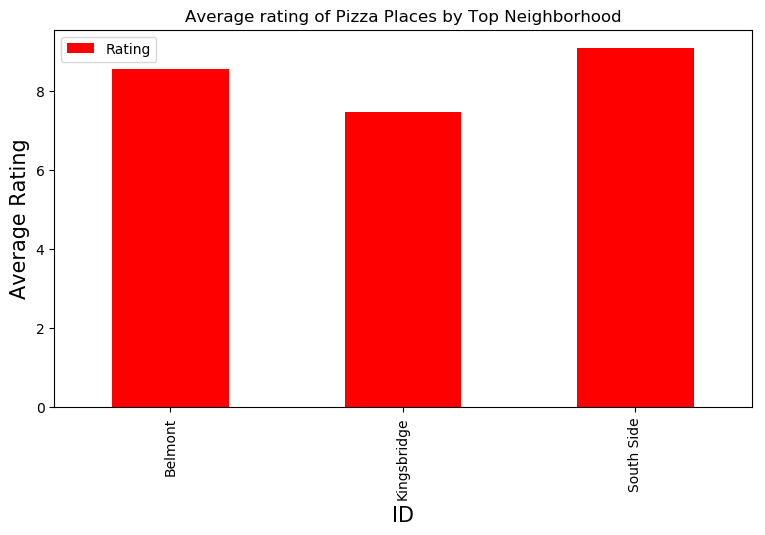

In [109]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Pizza Places by Top Neighborhood')
plt.xlabel('ID', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
nyc_pizza_stats.groupby('ID').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

## Now we can map our honed in results to visualize geography for tourists

In [ ]:
# NYC Map
latitude = 40.8
longitude = -74.00

# create map and display it
nyc_map = folium.Map(location=[latitude, longitude], zoom_start=11)
nyc_map

In [156]:
import folium
import pandas as pd

# Make a data frame with dots to show on the map
data = pd.DataFrame({
   'lat':[-73.8876,-73.8885,-74.2915,-73.884812,-73.8861,-73.8859,-73.9018,-73.9007,-73.906,-73.905,-73.90187,-73.90299,-73.90233,-73.959061,-73.95265,-73.95569,-73.95569,-73.9549,-73.9579],
   'lon':[40.8553,40.8548,40.583,40.8587698,40.8576,40.8586,40.8629,40.8849,40.8794,40.879,40.868898,40.87841,40.87841,40.88439,40.71217,40.71616,40.71215,40.7095,40.7085],
   'name':['Full Moon Pizzeria','Zero Otto Nove','Bellinis Pizza','Pugsley Pizza','Tony Tinas Pizza','University Pizza Restaurant','Bella Pizza','Kingsbridge Social Club,','Sams Pizza','Broadway Pizza Pasta','Little Caesars Pizza','Papa Johns Pizza','Dominos Pizza','LIndustrie Pizzeria','Leo','Emmy Squared','Roebling Pizza','Zeffs Pizzeria','Sabrinas Pizzeria'],
   'value':[9,8.8,8.6,9.2,9.2,6,9.2,9.4,9.4,7.8,7,6.6,4.6,9.6,9,9,9,9.6,8.4]
})
data

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lon'], data.iloc[i]['lat']],
      popup=data.iloc[i]['name'],
      radius=data.iloc[i]['value']*10000000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(nyc_map)


In [150]:
nyc_map


Map shows relative rating of pizza place by bubble size, we can conclude that based on the high density of well regarded pizza restaurants in South Side Brooklyn that this is the best location for pizza tourism.